# Symulacja gospodarcza 

Karol Doliński

-----

# 1. Cel projektu

<p style='text-align: justify;'>
Celem projektu jest wykonanie symulacji, która umożliwi określenie punktu ponawiania zamówień (poziomu zapasów) R i ilość zamawianą Q, tak by zminimalizować sumę średnich kosztów utrzymywania, zamawiania i braku zapasów w ciągu roku wg poniższych parametrów.

---

Założenia:

Jednostkowy koszt utrzymania zapasu (w PLN na 1 tonę na 1 dzień):
- dla wielkości zapasu do 20 ton: 20 PLN
- dla wielkości zapasu od 20 do 40 ton: 18 PLN
- dla wielkości zapasu od 40 do 60 ton: 16 PLN
- dla wielkości zapasu od 60 do 80 ton: 15 PLN
- dla wielkości zapasu od 80 do 100 ton: 14 PLN
- dla wielkości zapasu od 100 ton: 13 PLN

Koszt realizacji zamówienia (w PLN):
- dla wielkości zamówienia do 40 ton: 400 PLN
- dla wielkości zamówienia od 40 do 60 ton: 450 PLN
- dla wielkości zamówienia od 60 do 80 ton: 500 PLN
- dla wielkości zamówienia od 80 ton: 550 PLN

Strata spowodowana brakiem zapasu: 50 PLN za 1 tonę.

Czas dostawy:
- 2 dni z prawdopodobieństwem równym 0,3,
- 3 dni z prawdopodobieństwem równym 0,7.

---

Założenia dodatkowe:

    
1. Nie może mieć miejsce sytuacja, że złożone są dwa (lub więcej) zamówienia na raz. Kolejne zamówienie może zostać złożone dopiero jak poprzednie dotrze do magazynu.

2. Jeżeli danego dnia ktoś chce dokonać zamówienia na 100 ton, a w magazynie jest 60 ton, to dochodzi do sprzedaży tych 60 ton, wraz z naliczeniem straty za brakujące 40 ton, ale te 40 ton nie "przechodzi" na kolejne dni. Domniemuje się, że klient kupi te 40 ton w innym miejscu.

3. Zarówno sprzedaż jak i zamawianie jest dokonywane w wielokrotnościach 1 tony, nie ma możliwości zamawiania w mniejszych ilościach. Tzn. zamówienie może wynosić np. 50 ton, 51 ton, ale nie 50,1 tony. Dane zapisane są w tonach.
    
</p>

# 2. Zbiór danych historycznych

Badanie rozpoczęto od scharakteryzowania zbioru danych historycznych.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dane = pd.read_excel("dane_symulacja.xlsx", decimal = ",").round(0)

In [3]:
dane.head()

,dzienne_zapotrzebowanie
0,28.0
1,25.0
2,41.0
3,37.0
4,17.0


In [4]:
dane.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dzienne_zapotrzebowanie,361.0,30.515235,8.956402,2.0,25.0,31.0,36.0,56.0


In [5]:
random.seed(307)

Można zauważyć, że dane historyczne przypominają kształem rozkład normalny. Z uwagi na to zdecydowano się sprawdzić normalność za pomocą testu Shapiro-Wilka.

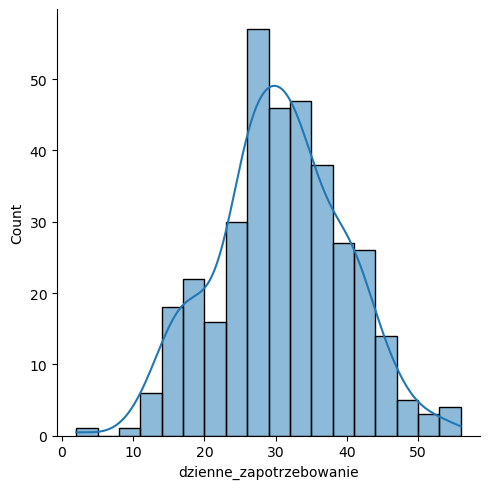

In [6]:
sns.displot(data=dane, x='dzienne_zapotrzebowanie', kde=True)
plt.show()

In [7]:
from scipy.stats import shapiro 
print(f'P-value testu Shapiro Wilka: {shapiro(dane.dzienne_zapotrzebowanie).pvalue}')

mu = dane.dzienne_zapotrzebowanie.mean()
sd = dane.dzienne_zapotrzebowanie.std()

P-value testu Shapiro Wilka: 0.2793427109718323


<p style='text-align: justify;'>
Hipoteza główna testu mówi, że dane pochodzą z rozkładu normalnego. P-value wynosi około 0,28, dlatego brak jest podstaw do odrzucenia hipotezy głównej. Można przyjąć normalność rozkładu danych historycznych. Ponadto średnia z próby wynosi około 31, a odchylenie standardowe jest równe około 9. W symulacji zapotrzebowanie na każdy dzień będzie losowane z rozkładu normalnego właśnie o tych parametrach.
</p>

# 3. Symulacja

Została wykonana symulacja, której celem jest ustalenie takiego poziomu R i Q, aby zminimalizować koszt całkowity. Przyjęto liczbę dni równą 365, a więc odpowiadającą pełnym 12 miesiącom. 

In [8]:
class Magazyn:
    
    
    def __init__(self, R, Q, liczba_dni_symulacji):
        wylosowane_dane = np.random.normal(loc=mu, scale=sd, size=liczba_dni_symulacji).round(0)
        self.dane = np.where(wylosowane_dane < 0, 0, wylosowane_dane)
        self.koszt_utrzymania_zapasu = 0
        self.koszt_realizacji_zamowien = 0
        self.koszt_straty_brak_zapasu = 0
        self.koszt_calkowity = 0
        self.strata_brak_zapasu = 50
        self.zapas = 0 
        self.Q = Q
        self.R = R
        self.czas_dostawy = 0
    
    
    def oblicz_koszt_utrzymania_zapasu(self):
        if (self.zapas < 20):
            self.koszt_utrzymania_zapasu += 20 * self.zapas
        elif (self.zapas < 40):
            self.koszt_utrzymania_zapasu += 18 * self.zapas
        elif (self.zapas < 60):
            self.koszt_utrzymania_zapasu += 16 * self.zapas
        elif (self.zapas < 80):
            self.koszt_utrzymania_zapasu += 15 * self.zapas
        elif (self.zapas < 100):
            self.koszt_utrzymania_zapasu += 14 * self.zapas
        else: 
            self.koszt_utrzymania_zapasu += 13 * self.zapas
            
            
    def zamow_i_oblicz_koszt_realizacji_zamowien(self):
        self.czas_dostawy = random.choices([2, 3], weights=[0.3, 0.7])[0]
        
        if(self.Q < 40):
            self.koszt_realizacji_zamowien += 400
        elif(self.Q < 60):
            self.koszt_realizacji_zamowien += 450
        elif(self.Q < 80):
            self.koszt_realizacji_zamowien += 500
        else:  
            self.koszt_realizacji_zamowien += 550

    
    def oblicz_koszt_straty_brak_zapasu(self, ilosc):
        self.koszt_straty_brak_zapasu += self.strata_brak_zapasu * ilosc
        
        
    def oblicz_koszt_calkowity(self):
        self.koszt_calkowity = self.koszt_utrzymania_zapasu + self.koszt_realizacji_zamowien + self.koszt_straty_brak_zapasu
        
        
    def wykonaj_symulacje(self):
        
        for i in self.dane: 
            # oblicz stan magazynu po dzisiejszym zapotrzebowaniu
            if(self.zapas >= i):
                self.zapas -= i
            else:
                self.oblicz_koszt_straty_brak_zapasu(i - self.zapas)
                self.zapas = 0
        
            # sprawdz czy nalezy zlozyc zamowienie
            if ((self.zapas <= self.R) & (self.czas_dostawy == 0)):
                self.zamow_i_oblicz_koszt_realizacji_zamowien()
                
            # oblicz koszt przechowywania zapasu, ktory zostal
            self.oblicz_koszt_utrzymania_zapasu()
            
            # sprawdz czy jest jakies aktywne zamowienie
            if (self.czas_dostawy == 0):
                pass
            elif (self.czas_dostawy == 1):
                self.zapas += self.Q
                self.czas_dostawy -= 1
            else:
                self.czas_dostawy -= 1
        
        self.oblicz_koszt_calkowity()
        

In [9]:
liczba_iteracji = 1000
zakres_r = 200
zakres_q = 150

df_wyniki = pd.DataFrame(columns = ['R', 'Q', 'koszt_calkowity'])

for r in range(1, zakres_r):
    for q in range(1, zakres_q):
        koszty = []
        for i in range(liczba_iteracji):
            x = Magazyn(r, q, liczba_dni_symulacji = 365)
            x.wykonaj_symulacje()
            koszty.append(x.koszt_calkowity)
        wynik = pd.DataFrame({'R':r, 'Q':q, 'koszt_calkowity':sum(koszty)/len(koszty)}, index=[0])
        df_wyniki = pd.concat([wynik, df_wyniki.loc[:]]).reset_index(drop=True)

df_wyniki["R"] = pd.to_numeric(df_wyniki["R"])
df_wyniki["Q"] = pd.to_numeric(df_wyniki["Q"])

df_wyniki_pivot = df_wyniki.pivot(index='R', columns='Q', values='koszt_calkowity')

Wyniki symulacji zostały przedstawione na wykresie, gdzie na osiach znalazły się parametry R i Q, a wartości przedstawiają koszt całkowity.

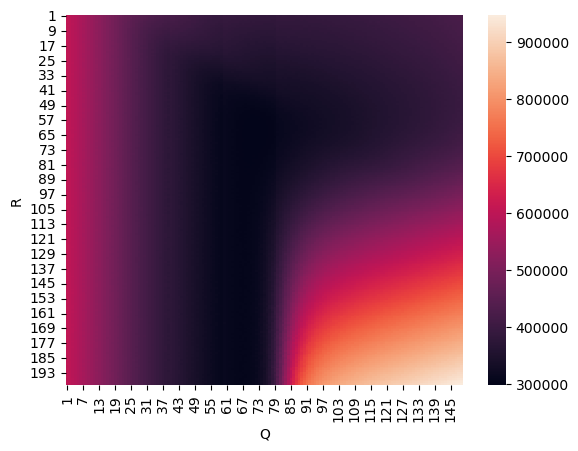

In [10]:
sns.heatmap(df_wyniki_pivot)
plt.show()

In [11]:
df_wyniki.sort_values(by=['koszt_calkowity']).head(10).reset_index(drop=True)

,R,Q,koszt_calkowity
0,61,71,297971.420
1,66,71,298105.852
2,63,71,298330.444
3,70,72,298336.448
4,63,72,298336.512
5,69,72,298400.520
6,69,71,298406.884
7,64,72,298464.888
8,68,72,298506.888
9,66,74,298564.444


# 4. Podsumowanie

<p style='text-align: justify;'>
W projekcie rozważano problem takiego wyznaczenia punktu ponawiania zamówień (poziomu zapasów) R i ilości zamawianej Q, by zminimalizować sumę średnich kosztów utrzymywania, zamawiania i braku zapasów w ciągu roku wg zdefiniowanych parametrów. W symulacji zmienną losową było zarówno zapotrzebowanie na każdy dzień (generowane z rozkładu normalnego), jak również czas oczekiwania na zamówienia, który wynosił 2 lub 3 dni. 
</p>

<p style='text-align: justify;'>
Na podstawie symulacji można określić punkt R równy 61 i Q równy 71 jako te dające najmniejszą wartość kosztu całkowitego. Warto zauważyć, że 10 najmniejszych wartości jest do siebie dosyć zbliżonych, dla R jest to przedział od 61 do 70, dla Q od 71 do 74. Na podstawie mapy termicznej (ang. <i>heatmap</i>) można zauważyć, iż jeśli rozważa się Q powyżej 90, to wartość kosztu całkowitego znacząco rośnie. Warto podkreślić, że symulacja tylko oszacowuje najlepsze parametry, które w realnej sytuacji mogą być inne, ponieważ nie są znane prawdziwe wartości zapotrzebowania i czasu dostawy. Niemniej taka symulacja jest właściwym narzędziem do wyznaczania poziomu Q i R, a jej wielokrotne powtarzanie zwiększa szansę na otrzymanie jak najlepszych parametrów, które pozwolą zmniejszyć koszta.
Natomiast przeprowadzając takie badanie w przedsiębiorstwach warto również wziąć pod uwagę zasoby jakie trzeba przeznaczyć na wykonanie symulacji. Może się zdarzyć sytuacja, że obliczenia wygenerują większe koszta dla firmy, niż zyski płynące z tych obliczeń. Z tego powodu koszta obliczeniowe są również istotnym czynnikiem, który należy brać pod uwagę wykonując o wiele większe niż ta symulacje. 
</p>  


